# CORD-19: Context words processing to find meaningful clues 

As a current student at the University of Puerto Rico at Mayagüez, I thought it would be a great opportunity to implement what I have learned in my classes while I contribute to the global threat known as COVID-19. The purpose of this kernel is to pre-process the papers of interest to build insightful models. I am far from done, but the first version includes a little Word2vec to vectorize the words and the proper visualization with t-SNE and matplotlib. I might change the models in the future implementations as my main intention is to display meaningful clues along the key words. Therefore, my plan is to implement a Word Sense Disambiguation Algorithm and some wrapper methods. 

Any help or feedback is very welcomed. In addition, this kernel is built upon CORD-19 - Data extraction functions from @saga21(very useful!).


Disclaimer: This kernel is still under construction. 

I will load output files from [xhlulu's kernel](https://www.kaggle.com/xhlulu/cord-19-eda-parse-json-and-generate-clean-csv), which contains a useful transformation of the json files in dictionaries to csv readable format. Go check it to give some credit!

In [1]:
import numpy as np 
import pandas as pd
pd.set_option('display.width', 100000) # Extend the display width to prevent split functions to not cover full text
import matplotlib.pyplot as plt
import time
import warnings 
from sklearn.manifold import TSNE
warnings.filterwarnings('ignore')
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import matplotlib.style as style 
%matplotlib inline

# NLP libraries
import spacy
from spacy.lang.en import English
from nltk.tokenize import word_tokenize 
from collections import Counter
from nltk.corpus import stopwords
from gensim.models import Word2Vec
from multiprocessing import cpu_count
import gensim.downloader as api
import re, string, unicodedata
from nltk.stem import LancasterStemmer, WordNetLemmatizer


# Any results you write to the current directory are saved as output.
biorxiv = pd.read_csv("/kaggle/input/cord-19-eda-parse-json-and-generate-clean-csv/biorxiv_clean.csv")

biorxiv['paper_text'] = biorxiv['text'].map(lambda x: re.sub('\[[^]],?#=*\]', '', x))# Convert the titles to lowercase
biorxiv['paper_text'] = biorxiv['paper_text'].map(lambda x: x.lower())

biorxiv.head(5)

,paper_id,title,authors,affiliations,abstract,text,bibliography,raw_authors,raw_bibliography,paper_text
0,c6039f8933305c9f44a44c81a15b321b6c2848dc,Far-UVC light: A new tool to control the sprea...,"David Welch, Manuela Buonanno, Veljko Grilj, I...",David Welch (Columbia University Medical Cente...,Abstract\n\nAirborne-mediated microbial diseas...,3\n\nAirborne-mediated microbial diseases repr...,"Global, regional, and national life expectancy...","[{'first': 'David', 'middle': [], 'last': 'Wel...","{'BIBREF0': {'ref_id': 'b0', 'title': 'Global,...",3\n\nairborne-mediated microbial diseases repr...
1,67a2ae408efcb6686a22ae27435c7e4fa10c4a21,Title: First 12 patients with coronavirus disease,"Zhang Y , Chen C , Zhu S , Shu C , Wang D , So...","Zhang Y , Chen C , Zhu S , Shu C , Wang D , So...","Abstract\n\nIntroduction: More than 93,000 cas...","INTRODUCTION\n\nIn December 2019, an outbreak ...","World Health Organization, , Coronavirus disea...","[{'first': 'Zhang', 'middle': ['Y'], 'last': '...","{'BIBREF0': {'ref_id': 'b0', 'title': 'World H...","introduction\n\nin december 2019, an outbreak ..."
2,982689f92bf67e90a43fc142c605da9a5045f756,Estimation of instant case fatality rate of CO...,"Lei Cao, Ting-Ting Huang, Jun-Xia Zhang, Qi Qi...","Lei Cao, Ting-Ting Huang, Jun-Xia Zhang, Qi Qi...",Abstract\n\nBackground The outbreak of coronav...,Introduction\n\nThe novel coronavirus pneumoni...,Outbreak of pneumonia of unknown etiology in W...,"[{'first': 'Lei', 'middle': [], 'last': 'Cao',...","{'BIBREF0': {'ref_id': 'b0', 'title': 'Outbrea...",introduction\n\nthe novel coronavirus pneumoni...
3,f33c6d94b0efaa198f8f3f20e644625fa3fe10d2,Sequencing of the human IG light chain loci fr...,"Corey T Watson, Karyn Meltz Steinberg, Tina A ...","Corey T Watson (Simon Fraser University, V5A 1...",Abstract\n\nGermline variation at immunoglobul...,Introduction\n\nAntibodies are essential compo...,"Janeway's immunobiology. 7 edn, K Murphy, P Tr...","[{'first': 'Corey', 'middle': ['T'], 'last': '...","{'BIBREF0': {'ref_id': 'b0', 'title': ""Janeway...",introduction\n\nantibodies are essential compo...
4,c8c052d27aaf8015316dcd2644fa5e0b3870cea1,Modeling the Comparative Impact of Individual ...,"Corey M Peak, Rebecca Kahn, Yonatan H Grad, La...",Corey M Peak (Harvard T.H. Chan School of Publ...,Abstract\n\nIndividual quarantine and active m...,"Introduction\n\nIn December 2019, Coronavirus ...","Coronavirus 2019-nCoV Global Cases, , , None; ...","[{'first': 'Corey', 'middle': ['M'], 'last': '...","{'BIBREF0': {'ref_id': 'b0', 'title': 'Coronav...","introduction\n\nin december 2019, coronavirus ..."


# 1. Filtering papers <a id="section-one"></a>

General studies like word frequency and such do require the full set of scientific papers. However, when dealing with specific tasks or topics, it's useful to select the subset of papers containing only certain words. Despite being very simple, the function defined in this section provides a list of paper_id containing a desired set of words.

In [2]:
# Filter papers containing all words in list
def filter_papers_word_list(word_list):
    papers_id_list = []
    text = " "
    for idx, paper in biorxiv.iterrows():
        text += paper.paper_text
        if all(x in paper.paper_text for x in word_list):
            papers_id_list.append(paper.paper_id)
            #text += paper.paper_text
            

    return paperTextProcessing(text, word_list)

Once the function that filters the papers is done, it calls paperTextProcessing. It is a simple text pre-processing function that splits the paper into lines and save the ones containing the words of our importance. Sequently, it removes stop words to improve the analysis of the future models implemented. 

In [3]:
def remove_non_ascii(words):
    """Remove non-ASCII characters from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words


def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words


def stem_words(words):
    """Stem words in list of tokenized words"""
    stemmer = LancasterStemmer()
    stems = []
    for word in words:
        stem = stemmer.stem(word)
        stems.append(stem)
    return stems


def lemmatize_verbs(words):
    """Lemmatize verbs in list of tokenized words"""
    lemmatizer = WordNetLemmatizer()
    lemmas = []
    for word in words:
        lemma = lemmatizer.lemmatize(word, pos='v')
        lemmas.append(lemma)
    return lemmas


def normalize(words):
    words = remove_non_ascii(words)
    words = remove_punctuation(words)
    words = lemmatize_verbs(words)
    return words


def paperTextProcessing(paper_text, word_list):
    
    relevant_sentences = []
    paper_text = paper_text.split(".")
    for sentence in paper_text:
        for word in word_list:
            if word in sentence:
                sentence1 = sentence.split()
                relevant_sentences.append(sentence1)

    stop_words = set(stopwords.words('english')) 
    
    for sentence in relevant_sentences:
        for word in stop_words:
            while(word in sentence):
                sentence.remove(word)
    
    final_corpus = []
    
    for sentence in relevant_sentences:
        final_corpus.append(normalize(sentence))
        
        
    return final_corpus

## 2. Word Clustering <a id="section-two"></a>

The following pre-processing functions prepare the corpus for the respective models. The function of word clustering get the respective embeddings in respect to the words we are looking for. In addition, data segmentation prepares the corpus transforming the sentences into the embeddings for further analyses with the semantic vectors obtained from Word2Vec. 

In [4]:
def dataSegmentation(corpus, vocabulary):
    sentences = []
    for sentence in corpus:
        num_sentence = []
        for word in sentence:
            if word in model:
                num_sentence.append(vocabulary[word])
            else:
                print(word)

        sentences.append(num_sentence)
        
    return sentences



def tsnePlotSimilarWords(title, labels, embedding_clusters, word_clusters, a, filename=None):
    plt.figure(figsize=(16, 9))
    colors = cm.rainbow(np.linspace(0, 1, len(labels)))
    for label, embeddings, words, color in zip(labels, embedding_clusters, word_clusters, colors):
        x = embeddings[:, 0]
        y = embeddings[:, 1]
        plt.scatter(x, y, c=color, alpha=a, label=label)
        for i, word in enumerate(words):
            plt.annotate(word, alpha=0.5, xy=(x[i], 
                        y[i]), xytext=(5, 2),
                         textcoords='offset points', 
                         ha='right', 
                         va='bottom', size=12)
    plt.legend(loc=1)
    plt.title(title)
    plt.grid(True)
    if filename:
        plt.savefig(filename, format='png', dpi=150, bbox_inches='tight')
    plt.show()
    

def wordClustering(model, keys):
    

    embedding_clusters = []
    word_clusters = []
    for word in keys:
        embeddings = []
        words = []
        for similar_word, _ in model.most_similar(word, topn=30):
            words.append(similar_word)
            embeddings.append(model[similar_word])
        embedding_clusters.append(embeddings)
        word_clusters.append(words)
        
    
    embedding_clusters = np.array(embedding_clusters)
    n, m, k = embedding_clusters.shape
    tsne_model_en_2d = TSNE(perplexity=25, n_components=2, init='pca', n_iter=3500, random_state=32)
    embeddings_en_2d = np.array(tsne_model_en_2d.fit_transform(embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)
    
    tsnePlotSimilarWords('COVID-19 Word Clustering', keys, embeddings_en_2d, word_clusters, 0.7,
                        'similar_words.png')
    
    

## 3. Modeling with the returned corpus <a id="section-three"></a>

Implementation of the Word2Vec models with the corpus recolected in the paperTextProcessing function. Based on the model, we build a t-SNE model and plot the words. 

In [5]:
from gensim.models import FastText

corpus = filter_papers_word_list(["transmission", "incubation", "propagation", "infection", "environment"])


model = FastText(corpus, min_count=2, workers=20, window=2, word_ngrams=1, alpha=0.02, hs=1)
newCorpus = filter_papers_word_list(["coronavirus", "virus", "risk", "disease", "infection", "transmission", "prevention", "SARS", "outbreak", "covid-19", "ethical", "social", "government", "symptoms", "vaccines"])
newCorpus.reverse()
model.train(newCorpus, epochs=20, total_examples=model.corpus_count, compute_loss=True)

# 4. FastText Embedding Visualization <a id="section-four"></a>


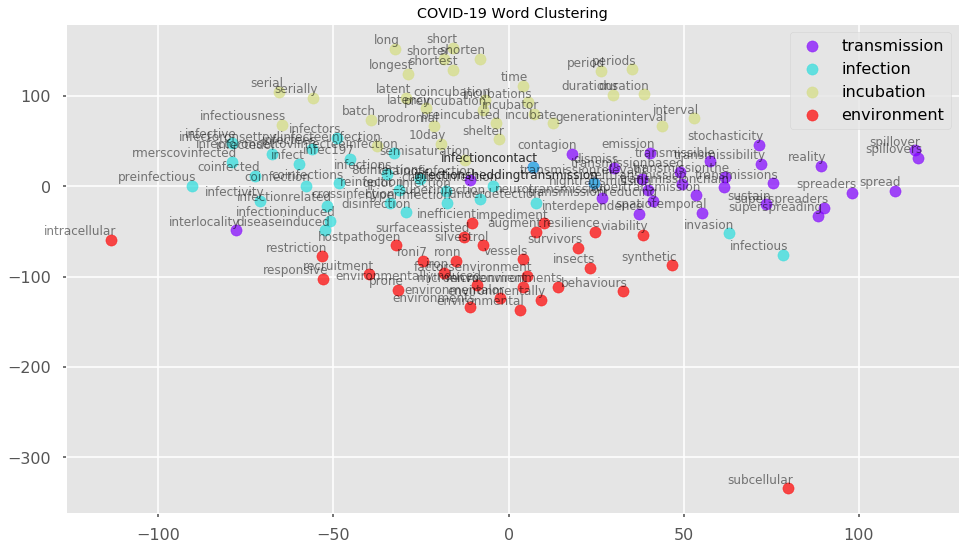

In [6]:
style.use('seaborn-poster')
style.use('ggplot')

keys = ['transmission', 'infection', 'incubation', 'environment']

wordClustering(model, keys)

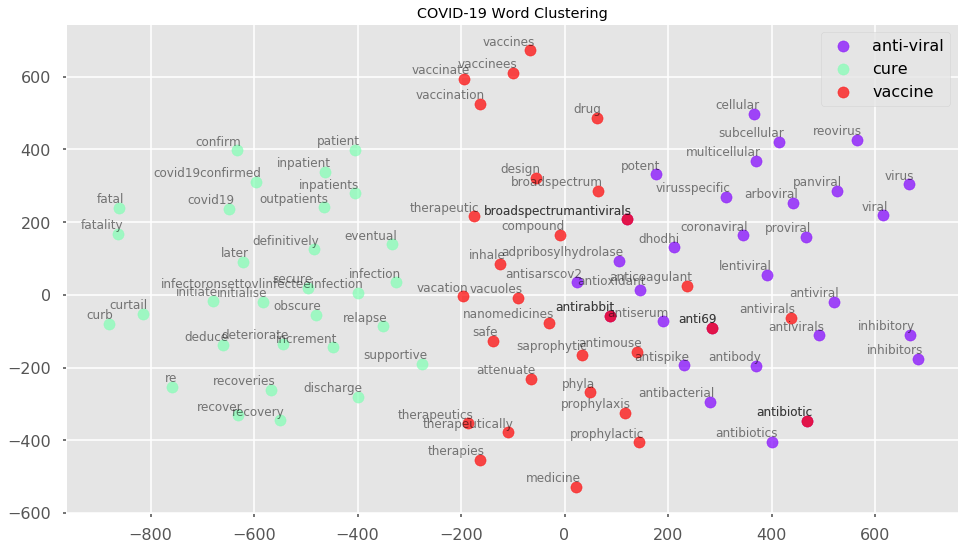

In [7]:
keys = ['anti-viral', 'cure', 'vaccine']

wordClustering(model, keys)

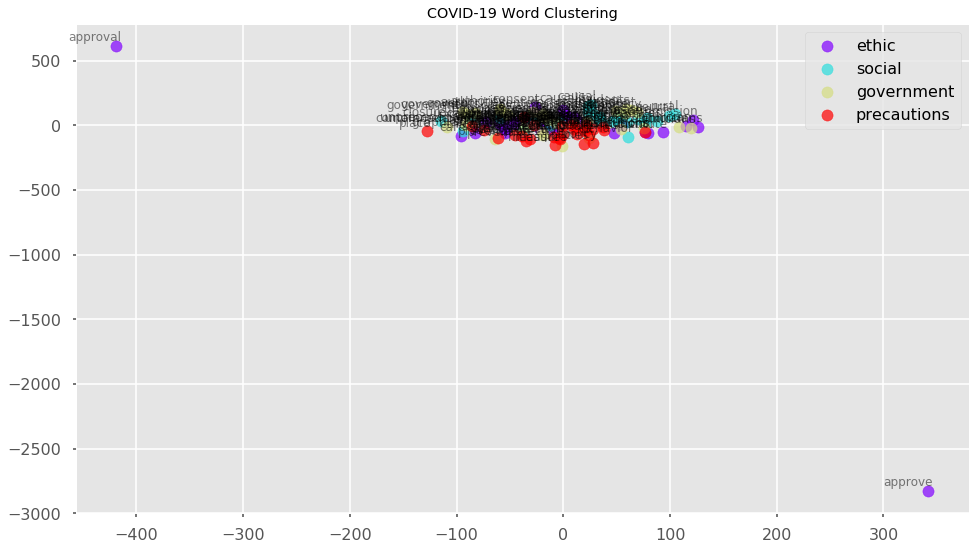

In [8]:
keys = ['ethic', 'social', 'government', 'precautions']

wordClustering(model, keys)

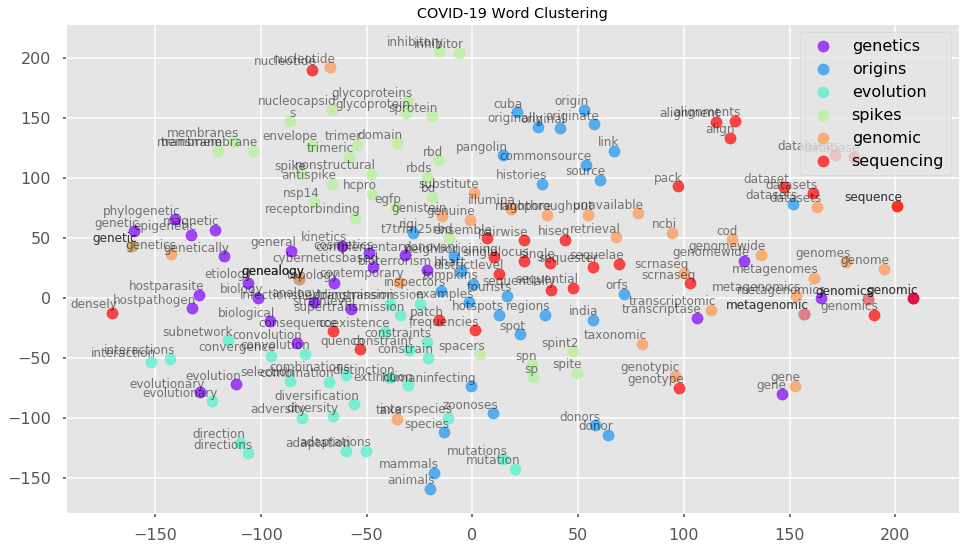

In [9]:
keys = ['genetics', 'origins', 'evolution', 'spikes', 'genomic', 'sequencing']

wordClustering(model, keys)

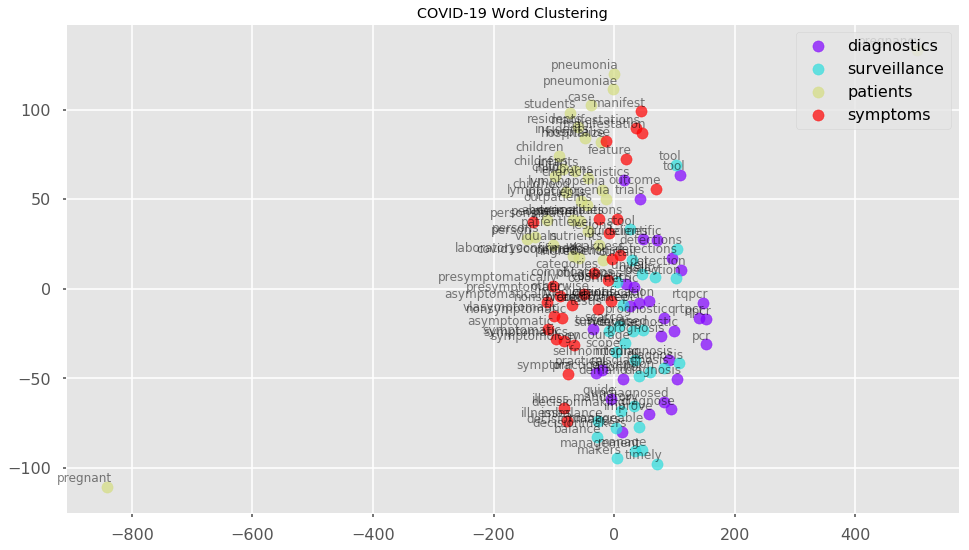

In [10]:
keys = ['diagnostics', 'surveillance', 'patients', 'symptoms']

wordClustering(model, keys)

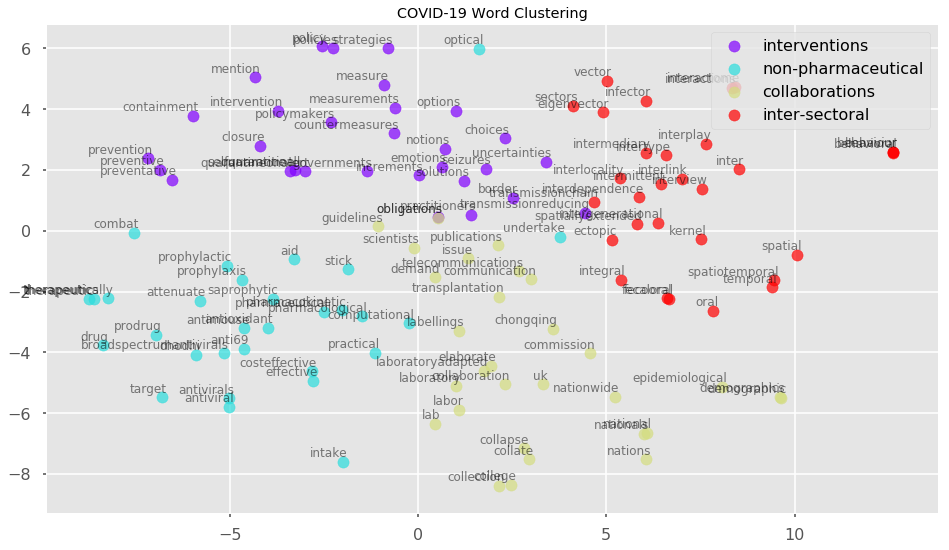

In [11]:
keys = ['interventions', 'non-pharmaceutical', 'collaborations', 'inter-sectoral']

wordClustering(model, keys)

In [12]:
import plotly.io as pio
#import plotly.plotly as py 
import plotly.graph_objects as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

init_notebook_mode(connected=True)

def tsne_plot(model):
    
    labels = []
    tokens = []

    for word in model.wv.vocab:
        tokens.append(model[word])
        labels.append(word)
    
    tsne_model = TSNE(perplexity=30, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(tokens)

       

    data = [
        go.Scatter(
            x=[i[0] for i in new_values],
            y=[i[1] for i in new_values],
            mode='markers',
            text=[i for i in model.wv.vocab],
            marker=dict(
            size=4,
            color = [len(i) for i in model.wv.vocab], #set color equal to a variable
            opacity= 0.8,
            colorscale='Viridis',
            showscale=False
        )
        )
    ]
    layout = go.Layout()
    layout = dict(
              yaxis = dict(zeroline = False),
              xaxis = dict(zeroline = False)
             )
    
    
    
    fig = go.Figure(data=data, layout=layout)
    
    fig.update_layout(title=
    {
        'text': "Semantic word representations by FastText model",
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})
    
    
    file = plot(fig)
    pio.show(fig)

tsne_plot(model)


Find most similar words

In [13]:
model.most_similar('vaccine', topn=20)



[('vaccinees', 0.9404691457748413),
 ('vaccines', 0.8960931301116943),
 ('vaccinate', 0.7554996609687805),
 ('vaccination', 0.7454636096954346),
 ('vacuoles', 0.5135418176651001),
 ('safe', 0.44115179777145386),
 ('drug', 0.43894216418266296),
 ('nanomedicines', 0.4367471933364868),
 ('broadspectrumantivirals', 0.42786699533462524),
 ('therapies', 0.4216901659965515),
 ('prophylaxis', 0.4158869981765747),
 ('broadspectrum', 0.4116141200065613),
 ('saprophytic', 0.4114908277988434),
 ('antimouse', 0.41132956743240356),
 ('anti69', 0.40977030992507935),
 ('compound', 0.4073953628540039),
 ('prophylactic', 0.4021064341068268),
 ('antibiotic', 0.3991921544075012),
 ('medicine', 0.39835745096206665),
 ('vacation', 0.3970434069633484)]

This kernel is still under construction. 

In [14]:
model.most_similar('origin', topn=20)


[('origins', 0.891379714012146),
 ('originate', 0.7385333180427551),
 ('original', 0.7192407846450806),
 ('originally', 0.5951158404350281),
 ('commonsource', 0.4730444550514221),
 ('link', 0.43697941303253174),
 ('india', 0.4306623637676239),
 ('source', 0.41125819087028503),
 ('animals', 0.3996409773826599),
 ('pangolin', 0.3925682306289673),
 ('animaltohuman', 0.3860202133655548),
 ('shade', 0.3781059980392456),
 ('lin', 0.3734648823738098),
 ('reservoir', 0.3611815869808197),
 ('cuba', 0.35708314180374146),
 ('via', 0.35590219497680664),
 ('reservoirs', 0.35405656695365906),
 ('linker', 0.3528633713722229),
 ('jilin', 0.352740615606308),
 ('animal', 0.351806640625)]